In [1]:
import numpy as np
import scipy.stats
import torch

confidence = 0.95

def measure(value, tolerance=0, factor=1, intercept=0):
	"""Measure a value with uncertainty, returning a torch.Tensor with an extra uncertainty attribute."""
	systematic_error = tolerance * confidence	# assuming the data is uniformly distributed within the tolerance

	if isinstance(value, (list, np.ndarray)):
		ME = margin_of_error(np.array(value))
		mean_value = (np.mean(value) - intercept) * factor
		uncertainty = np.sqrt(ME**2 + systematic_error**2) * factor
	else:
		mean_value = (value - intercept) * factor
		uncertainty = systematic_error * factor

	# Create a Tensor object and attach the uncertainty as an attribute
	result_tensor = torch.tensor(mean_value, dtype=torch.float, requires_grad=True)
	setattr(result_tensor, 'uncertainty', uncertainty)

	print(f'Measured Value {mean_value} ± {uncertainty}')
	return result_tensor

def margin_of_error(value):
	"""Calculate Margin of Error (the uncertainty associated with random error), using the t-distribution."""
	return scipy.stats.t.ppf((1 + confidence) / 2, len(value) - 1) * np.std(value, ddof=1) / np.sqrt(len(value))

def uncertainty(result, inputs):
	"""Calculate the uncertainty of a result based on the uncertainties of its inputs."""
	if not all(hasattr(input, 'uncertainty') for input in inputs if isinstance(input, torch.Tensor)):
		raise ValueError("All inputs must have an 'uncertainty' attribute.")

	derivatives = []
	for input in inputs:
		if isinstance(input, torch.Tensor) and hasattr(input, 'uncertainty'):
			input.requires_grad_(True)
			derivative = torch.autograd.grad(outputs=result, inputs=input, retain_graph=True)[0]
			derivatives.append(input.uncertainty * derivative)

	derivatives = torch.tensor(derivatives)
	total_uncertainty = torch.sqrt(torch.sum(derivatives ** 2))
	setattr(result, 'uncertainty', total_uncertainty.item())
	setattr(result, 'contributions', derivatives)

	print(f'Result: {result.item()} ± {total_uncertainty.item()}')
	return result

def relative_uncertainty(value : torch.Tensor):
	"""Calculate the relative uncertainty of a value."""
	if not hasattr(value, 'uncertainty'):
		raise ValueError("The input must have an 'uncertainty' attribute. Call the `uncertainty` function first.")
	return value.uncertainty / value.item()

In [2]:
import matplotlib.pyplot as plt

In [3]:
measure([
	.54, .12, .48
]
)

Measured Value 0.38000000000000006 ± 0.5642876153562673


tensor(0.3800, requires_grad=True)

In [4]:
D_original = [120.356, 137.403, 153.789, 166.874, 179.64, 190.491, 202.712, 213.199, 223.324, 233.955]
D_original = [120.356, 137.403, 153.789, 166.874, 179.64, 190.491, 203.397, 213.199, 223.324, 234.182]
# D_original = [120.356, 135.703, 153.789, 166.874, 179.64, 190.491, 203.397, 213.199, 223.324, 233.955]
D_real = np.array(D_original)

factor = 278 + np.mean([
	.54, .12, .48
]
)
factor = 6 / factor

D_real = D_real * factor * 1e-3

D_numbered = list(zip(range(3, 13), D_real))
# remove_index = [1, 6, 7]
remove_index = [1, 8]
# remove_index = [9]

# remove the data
for index in remove_index:
	D_numbered.pop(index)

D_numbered = np.array(D_numbered)


D_numbered

array([[3.00000000e+00, 2.59406567e-03],
       [5.00000000e+00, 3.31465623e-03],
       [6.00000000e+00, 3.59668080e-03],
       [7.00000000e+00, 3.87182987e-03],
       [8.00000000e+00, 4.10570443e-03],
       [9.00000000e+00, 4.38387097e-03],
       [1.00000000e+01, 4.59513614e-03],
       [1.10000000e+01, 4.81336303e-03]])

In [5]:
# convert the y-value into measurement
D_k = [measure(value, tolerance=0.0005 * factor * 1e-3, factor=1) for _, value in D_numbered]
k = D_numbered[:, 0]

Measured Value 0.002594065665636899 ± 1.0237804439974136e-08
Measured Value 0.0033146562253035415 ± 1.0237804439974136e-08
Measured Value 0.003596680796034198 ± 1.0237804439974136e-08
Measured Value 0.0038718298728356916 ± 1.0237804439974136e-08
Measured Value 0.004105704432789712 ± 1.0237804439974136e-08
Measured Value 0.004383870967741936 ± 1.0237804439974136e-08
Measured Value 0.004595136144837992 ± 1.0237804439974136e-08
Measured Value 0.00481336302895323 ± 1.0237804439974136e-08


In [6]:
x = k
y = [D ** 2 for D in D_k]

# calculate the linear regression
x = torch.tensor(x, dtype=torch.float)

# using formula a = (nΣxy - ΣxΣy) / (nΣx^2 - (Σx)^2)
# and b = (Σy - aΣx) / n
n = len(x)
sum_x = torch.sum(x)
sum_y = torch.sum(torch.stack(y))
sum_xy = torch.sum(torch.stack([x * y for x, y in zip(x, y)]))
sum_x2 = torch.sum(x ** 2)

a = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x ** 2)
b = (sum_y - a * sum_x) / n

lambda_ = 589.3e-9

R = a / (4 * lambda_)
d_0 = b / (16 * R)

# calculate the uncertainty of the slope
uncertainty(R, D_k)
uncertainty(d_0, D_k)


Result: 0.8696064352989197 ± 4.688263743446441e-06
Result: 4.5475378129822275e-08 ± 5.742945615588857e-12


tensor(4.5475e-08, grad_fn=<DivBackward0>)

In [7]:
4.688263743446441e-06 * 3, 5.742945615588857e-12 * 3

(1.4064791230339324e-05, 1.722883684676657e-11)

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHe

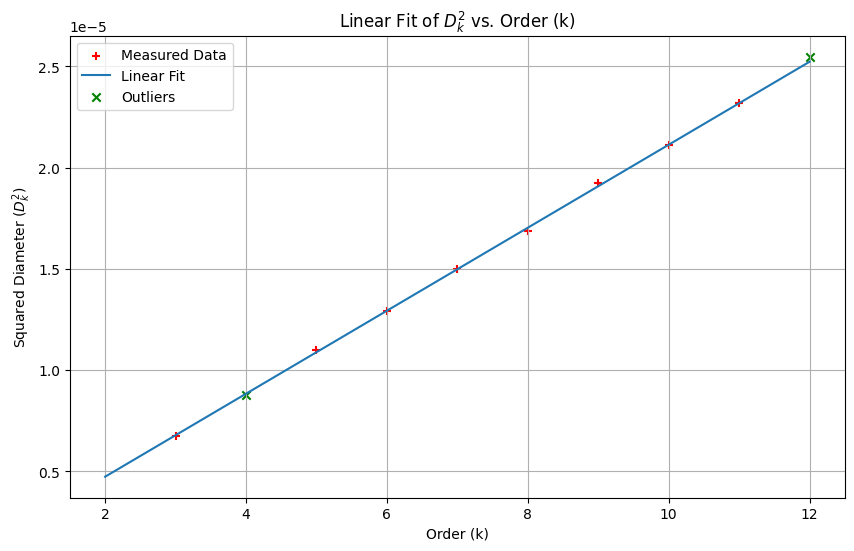

(0.8696066860342098, 4.547493472907134e-08, 0.9998481992042157)

In [8]:
# formula: D_k^2 = 4 * R * lambda * k + 16 * R * d_0
D_k = D_numbered

lambda_ = 589.3e-9

outliers = [1, 9]
outlier_k = [4, 12]
outlier_D_k = [D_real[1], D_real[9]]
outlier_D_k = np.array(outlier_D_k)
outlier_D_k_squared = outlier_D_k ** 2

# Extracting k and D_k^2 from the given data
k = D_k[:, 0]
D_k_squared = D_k[:, 1] ** 2


from scipy.stats import linregress

# The formula D_k^2 = 4 * R * lambda * k + 16 * R * d_0 can be rearranged into:
# D_k^2 = (4 * lambda) * R * k + (16 * d_0) * R
# This resembles a linear equation y = mx + c, where y = D_k^2, x = k, m = (4 * lambda) * R, and c = (16 * d_0) * R

# Performing linear regression to find m and c
slope, intercept, r_value, p_value, std_err = linregress(k, D_k_squared)

# Calculating R and d_0 from slope(m) and intercept(c)
R = slope / (4 * lambda_)
d_0 = intercept / (16 * R)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(k, D_k_squared, color='red', label='Measured Data', marker='+')
x = np.linspace(2, 12, 2)
# x = k
plt.plot(x, slope * x + intercept, label='Linear Fit')
plt.scatter(outlier_k, outlier_D_k_squared, color='green', label='Outliers', marker='x')

plt.xlabel('Order (k)')
plt.ylabel('Squared Diameter ($D_k^2$)')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.title('Linear Fit of $D_k^2$ vs. Order (k)')
plt.legend()
plt.grid(True)
plt.show()

R, d_0, r_value

In [9]:
slope, a

(2.0498368803198394e-06, tensor(2.0498e-06, grad_fn=<DivBackward0>))